## **Environment Setup**
Run all when initiating session

In [ ]:
# retrieve config file, if using colab (nothing should happen if you use Windows)
!cp './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/config.py' '.'
!mkdir data
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/data/' '.'
!mkdir models
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/models/' '.'
!mkdir technical
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/technical/' '.'
!mkdir trainers
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/trainers/' '.'
!mkdir utils
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/utils/' '.'

In [ ]:
from config import *                            # config.py
from matplotlib import pyplot as plt 
import os
%matplotlib inline

## **GCS Integration**
Run all when initiating session

In [ ]:
if isWindows():
  import utils.gcs_windows as gcs 
elif isColab():
  import utils.gcs_colab as gcs
else:
  raise NotImplementedError('OS is not supported yet')

gcs.init()

BUCKET1_GS, BUCKET1 = gcs.mount_bucket("ffhq-1024-lips-1")
#BUCKET1_GS = BUCKET1 = "C:\\Users\\comtalyst\\Documents\\Local_Workspace\\testdata"

## **Model Environment Setup**

In [ ]:
from technical.accelerators import strategy
from data.pipeline import *
from trainers.stylegan import train, load_checkpoint, gen_loss_dict, disc_loss_dict
from models.discriminator import Discriminator
from models.generator import Generator

In [ ]:
generator = Generator(strategy, '512')
discriminator = Discriminator(strategy, '512')
current_progress = 0

In [ ]:
##### Load saved models here if not the first generation (SavedModel) #####
RUN = False
# Warning, using this format on colab may cause the "'NoneType' object has no attribute 'get'" bug
if RUN:
  last_epoch = 0
  current_progress = 2
  generator.load(its_progress=current_progress, strategy=strategy, fname="generator" + "-p_" + str(current_progress) + "-e_" + str(last_epoch))
  discriminator.load(its_progress=current_progress, strategy=strategy, fname="discriminator" + "-p_" + str(current_progress) + "-e_" + str(last_epoch))
else:
  print("Running switch for this cell is off, skipping")

In [ ]:
##### Load saved models here if not the first generation (checkpoint) #####
RUN = True
# make sure to add progress to the models until reach intended checkpoint's progress
if RUN:
  load_checkpoint(generator, discriminator, strategy, True)
else:
  print("Running switch for this cell is off, skipping")

In [ ]:
##### Add progress to models here #####
RUN = True
if RUN:
  generator.progress(strategy)
  discriminator.progress(strategy)
  current_progress += 1
else:
  print("Running switch for this cell is off, skipping")

In [ ]:
LATENT_SIZE = Generator.LATENT_SIZE 
IMAGE_SHAPE = generator.image_shape
IMAGE_SIZE = [IMAGE_SHAPE[0], IMAGE_SHAPE[0]]
print("Latent size: " + str(LATENT_SIZE))
print("Image shape: " + str(IMAGE_SHAPE))

In [ ]:
##### Prepare dataset #####
training_dataset = get_dataset(BUCKET1_GS, True, True, True, BUCKET1, image_size=IMAGE_SIZE)

## **Pre-Train Testing**

In [ ]:
noise = tf.random.normal([1,LATENT_SIZE])

In [ ]:
## full model
image = generator.model(noise, training=False)
plt.imshow(image[0])
print(discriminator.model(image, training=False).numpy())

In [ ]:
## fading model 
# alpha 0 should be the same as full output from prev generation
# alpha 1 should be the same as full output from current generation
generator.setAlpha(1)
image = generator.model_fade(noise, training=False)
plt.imshow(image[0])
print(discriminator.model_fade(image, training=False).numpy())

## **Training**

In [ ]:
FADE_EPOCHS = 200
EPOCHS = 600

if isColab():                   # some colab's tpu side bug
  import numpy as np
  np.rank = np.ndim
train(generator, discriminator, training_dataset, FADE_EPOCHS, EPOCHS, BATCH_SIZE, strategy, lr=[5e-5, 5e-5])

## **Saving**

In [ ]:
generator.save(0, strategy)
discriminator.save(0, strategy)

## **Testing**

In [ ]:
noise = tf.random.normal([1,LATENT_SIZE])
image = generator.model(noise, training=False)
plt.imshow(image[0])
print(discriminator.model(image, training=False).numpy())

## **Experiments**
Just a playground for trying out codes, nothing related at all, do not execute

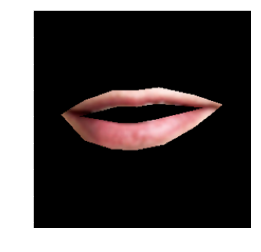

In [39]:
### just code testing

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt 
import os
from PIL import Image
%matplotlib inline

fbytes = tf.io.read_file('samples\\musk_lips_cropped.png')
image = tf.image.decode_png(fbytes, channels=4)
max_resize = 0.5
random_scale = max_resize + np.random.rand()*(1 - max_resize)
image = tf.image.central_crop(image, random_scale)
image = Image.fromarray(image.numpy())
image = image.resize((206, 206))
image = tf.convert_to_tensor(np.array(image))
plt.imshow(image)

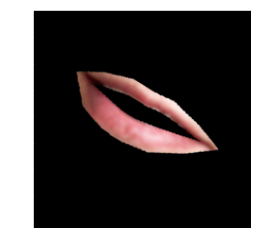

In [49]:
plt.imshow(tf.keras.preprocessing.image.random_rotation(image.numpy(), 40, row_axis=0, col_axis=1, channel_axis=2))